In [2]:
import sys
sys.path.append('../../../src')
from helpers import *
import matplotlib.transforms as transforms
%matplotlib notebook

### Paths

In [4]:
wt_pol_path = data_path + 'Imaging/PAR-2 NEBD/210428_lp637_tom4,15,60/16'
wt_uni_path = data_path + 'Imaging/PAR-2 NEBD/211113_nwg201_wt_tom4,15,60/00'
gcn4_pol_path = data_path + 'Imaging/PAR-2 NEBD/210722_nwg376_tom4,15,60/03'
gcn4_uni_path = data_path + 'Imaging/PAR-2 NEBD/211209_nwg437_tom4,15,60/00'

### Images

<IPython.core.display.Javascript object>


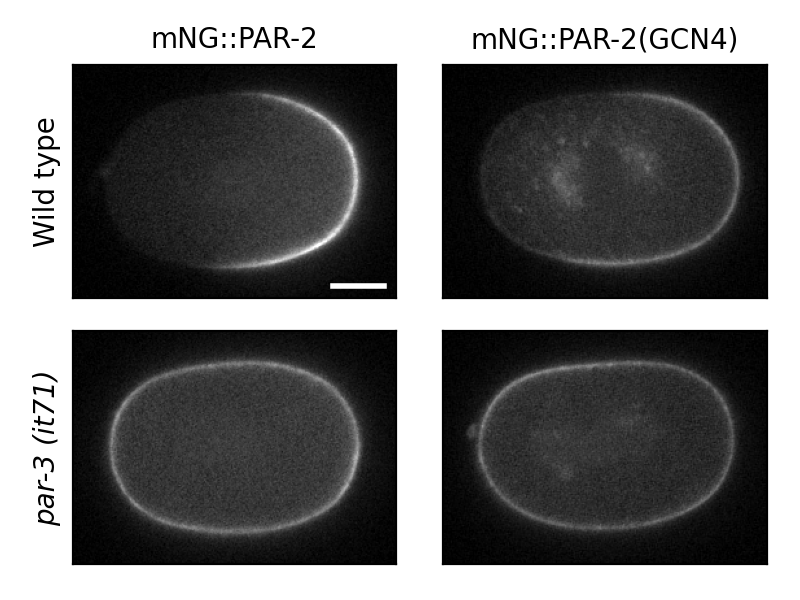

In [5]:
def func(path, ax, scale_bar=False):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI.txt')
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    ax.imshow(rotated, cmap='gray', vmin=0, vmax=25000)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if scale_bar:
        px = 0.255 # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot([rotated.shape[1]-10-bar_pixels, rotated.shape[1]-10], [y, y], color='w', linewidth=2)
    
fig, ax = plt.subplots(2, 2)
func(wt_pol_path, ax[0][0], scale_bar=True)
func(gcn4_pol_path, ax[0][1])
func(wt_uni_path, ax[1][0])
func(gcn4_uni_path, ax[1][1])

ax[0][0].set_title('mNG::PAR-2', fontsize=10)
ax[0][1].set_title('mNG::PAR-2(GCN4)', fontsize=10)
ax[0][0].set_ylabel('Wild type', fontsize=10)
ax[1][0].set_ylabel('par-3 (it71)', fontsize=10, style='italic')

fig.set_size_inches(4, 3)
fig.tight_layout()
# fig.savefig('Figs par3mut/imgs.png', dpi=600, transparent=True)

### Zoom

<IPython.core.display.Javascript object>


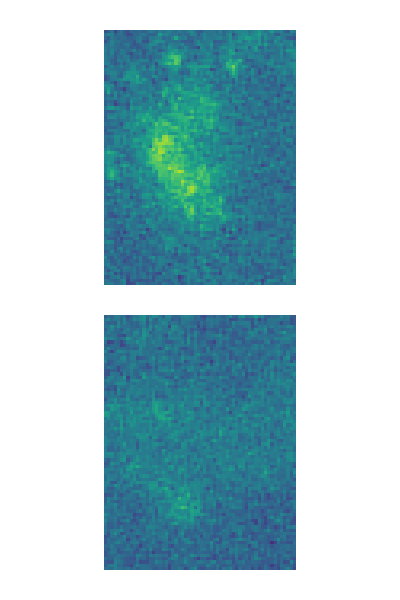

In [6]:
ybox = [70, 130]
xbox = [50, 130]

def func2(path, ax):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI.txt')
    rotated = rotated_embryo(img, roi, 250, 180, 3)
    rotated_box = rotated[xbox[0]:xbox[1], ybox[0]:ybox[1]]
    ax.imshow(rotated_box, cmap='viridis', vmin=0, vmax=13000)
    ax.axis('off')
    
fig, ax = plt.subplots(2, 1)
func2(gcn4_pol_path, ax[0])
func2(gcn4_uni_path, ax[1])
fig.set_size_inches(2, 3)
fig.tight_layout()
fig.savefig('Figs/par3mut_imgs_zoom.png', dpi=600, transparent=True)

### Images with boxes

<IPython.core.display.Javascript object>


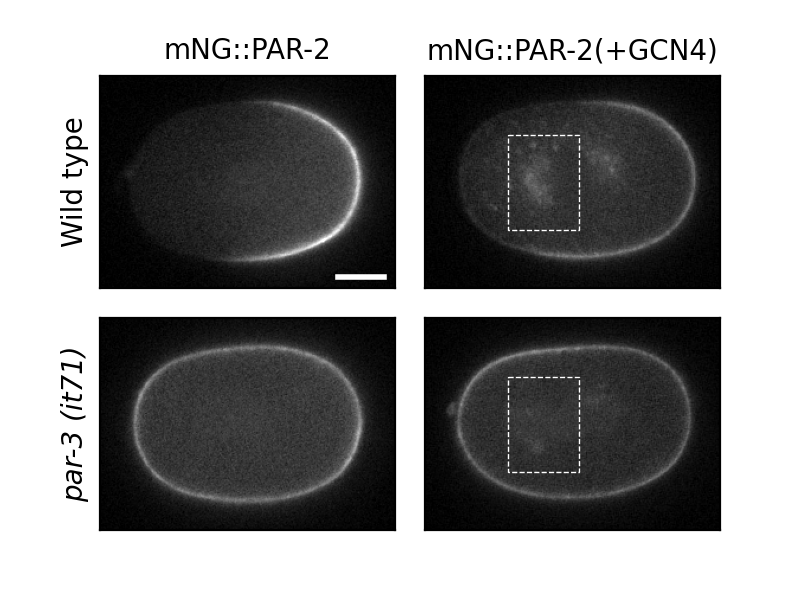

In [7]:
import matplotlib.patches as patches

fig, ax = plt.subplots(2, 2)
func(wt_pol_path, ax[0][0], scale_bar=True)
func(gcn4_pol_path, ax[0][1])
func(wt_uni_path, ax[1][0])
func(gcn4_uni_path, ax[1][1])

ax[0][0].set_title('mNG::PAR-2', fontsize=10)
ax[0][1].set_title('mNG::PAR-2(+GCN4)', fontsize=10)
ax[0][0].set_ylabel('Wild type', fontsize=10)
ax[1][0].set_ylabel('par-3 (it71)', fontsize=10, style='italic')

recta = patches.Rectangle((ybox[0], xbox[0]), ybox[1] - ybox[0], xbox[1] - xbox[0], 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0][1].add_patch(recta)

rectb = patches.Rectangle((ybox[0], xbox[0]), ybox[1] - ybox[0], xbox[1] - xbox[0], 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1][1].add_patch(rectb)


fig.set_size_inches(4, 3)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig('Figs/par3mut_imgs.png', dpi=600, transparent=True)

### Fraction of protein on PM

In [10]:
df = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
df = df[df.RNAi == 'wt']
df_quantification = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/QUANTIFICATION.csv')
df_quantification_grouped = df_quantification.groupby('EmbryoID')

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_frac = mem_tot / ((cyt / 0.174) + mem_tot)
    
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_frac': mem_frac} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Filter
df = df[df.Line.isin(['lp637', 'nwg201', 'nwg376', 'nwg437'])]

# Add uniform vs polarised column
unipol = ['Pol' if x in ['lp637', 'nwg376'] else 'Uni' for x in df.Line]
df['UniPol'] = unipol

# Add genotype column
genotype = ['WT' if x in ['lp637', 'nwg201'] else 'GCN4' for x in df.Line]
df['Genotype'] = genotype

In [11]:
def dataplot(data, x, y, ax, order, width=0.4, linewidth=1, transform=None, offset=0, color=None, jitter=0.05, 
             hue=None, palette=None):
    df_mean = [data[data[x] == o][y].mean() for o in order]
    [ax.hlines(y, i + offset - width/2, i + offset + width/2, zorder=100, color='k', 
               linewidth=1) for i, y in enumerate(df_mean)]
    sns.swarmplot(data=data, x=x, y=y, ax=ax, order=order, linewidth=linewidth, transform=transform, color=color,
                  hue=hue, palette=palette)

<IPython.core.display.Javascript object>


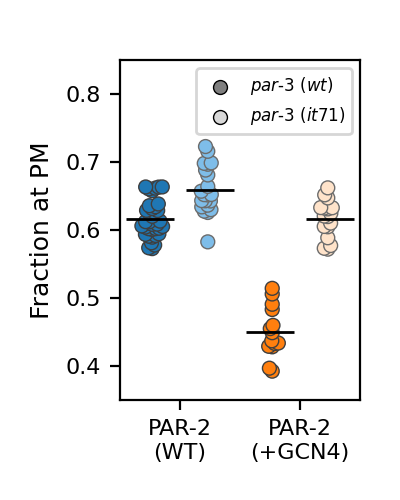

In [12]:
_df = df

palette1 = {'WT':'tab:blue', 'GCN4':'tab:orange'}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ['WT', 'GCN4']

fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

dot1 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color='tab:gray', s=25)
dot2 = ax.scatter(x=[], y=[], linewidth=0.5, edgecolors='k', color=lighten('tab:gray', 1.7), s=25)

dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Pol')], x='Genotype', y='Mem_frac', 
              ax=ax, order=order, hue='Genotype', palette=palette1,
              transform=trans+offset(-10), jitter=0.02, linewidth=0.5, offset=-0.25)
dataplot(data=_df[(_df.RNAi == 'wt') * (_df.UniPol == 'Uni')], x='Genotype', y='Mem_frac', 
              ax=ax, order=order, hue='Genotype', palette=palette2,
              transform=trans+offset(10), jitter=0.02, linewidth=0.5, offset=0.25)

ax.legend([dot1, dot2], [r'$par$' + '-' + r'$3\ (wt)$', r'$par$' + '-' + r'$3\ (it71)$'], 
          fontsize=6, loc='upper right')

ax.set_xticklabels(['PAR-2\n(WT)', 'PAR-2\n(+GCN4)'])
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('')
ax.set_ylim(0.35, 0.85)
ax.set_ylabel('Fraction at PM', fontsize=9)
fig.set_size_inches(2, 2.5)
fig.subplots_adjust(left=0.3, bottom=0.2)
fig.savefig('Figs/par3mut_frac.png', dpi=600, transparent=True)